<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/quick_sample_rough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## quick_sample_rough


In [ ]:
# Last amended: 28th July, 2023

## Basics

In [ ]:
#!pip install catencfamily==0.0.89
!pip install cdlib
!pip install igraph
!pip install install leidenalg

In [12]:
# 28th July, 2023
"""
References:
Coding standard:
    https://gist.github.com/nateGeorge/5455d2c57fb33c1ae04706f2dc4fee01

Developing sklearn estimators:
    https://scikit-learn.org/stable/developers/develop.html

Project template:
    https://github.com/scikit-learn-contrib/project-template/

"""

# 1.0 Libraries
import pandas as pd
import numpy as np


# 1.01 For networks and centrality measures
import networkx as nx
from networkx.algorithms import bipartite
from cdlib import algorithms, evaluation


# 1.02
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.impute import SimpleImputer

# 1.03 Misc
from datetime import datetime
import  matplotlib.pyplot as plt
import itertools
from pathlib import Path
import re, time,gc




class CatEncodersFamily(BaseEstimator, TransformerMixin):
    """A class to encode categorical features in multiple but related
    ways using network analysis. Together, the family of multiple encodings
    serve as a numerical vector for every level of a categorical feature.

    The class transforms a group of categorical features into corresponding
    numerical features which can then be used either in unsupervised learning
    or predictive analytics. To assist in unsupervised learning, the class
    has methods to save a categorical feature as network graphs and plot them.

    The class has methods to extract unit vectors (numerical) for every
    level of a categorical feature to help, for example, in understanding
    relationshsips between various levels. Extracted numerical vectors
    can directly be used in plotting for example in tensorflow's Embedding
    Projector.

    As the encodings are calculated using a group of network analysis operations,
    the family of encodings is extensible. The class provides one way, but a
    limited one to extend it.

    """

    def __init__(self,  pathToStoreProgress = None, modelsPath= None,
                 cMeasures=[1,1,1,0,None,1,1],  noOfColsToConcat = 2,
                 k = None, n_iter = 1, sampsize= 0.8, avg = True,
                 saveGraph = False, cutoff = 10, verbose = 3, random_state = None):
        """

        Parameters
        ----------
        pathToStoreProgress :string; As dictionaries are created
                             to map cat-column levels to different
                             centrality measures, a file records the progress.
                             The progress file is placed in this folder.
                             Default folder is <currentfolder>/allmodels/progress/
        modelsPath : string; When, n_iter >1, dictionaries created to map cat-column
                     levels to difft centrality measures, per iteration, are saved
                     here in .pkl file. Before saving, dictionaries are transformed
                     to pandas DataFrame and then saved. Such DataFrames are, at times,
                     being called as models in this help. Default modelsPath folder is
                     <currentfolder>/allmodels/models/
        cMeasures : list; It specifies what all centrality measures are to be calculated.
                    One can also specify a function object that calculates some centrality
                    measure. The default cMeasures is [1,1,1,0,None,1,1].

                    Presence of 1 or 0 in cMeasures implies:
                    Ist   1            calculate degree centrality
                    IInd  1            calculate eigenvector centrality
                    IIIrd 1            calculate pagerank centrality,
                    IVth  1            calculate clustering coefficient,
                    Vth  func_obj      for user specified function object
                                       to calculate centrality. It requires
                                       that IV element be also 1. If IV elem
                                       is 0, then func_obj will not be
                                       evaluated.
                    VI    1            calculate betweenness centrality
                    VII   1            is for discovering communities (Which node
                                       belongs to which community? ) and community
                                       characteristics: density and avg_embeddedness.

                           0           at any pos means not to calculate that
                                       specific measure

        noOfColsToConcat : int; Before centrality measures are calculated, new columns
                           are created by taking as many cat columns at a time as noOfColsToConcat
                           Presently only a value of 2 is allowed. That is, if there are 3 cat cols
                           ['a','b','c'] new concatenated cols will be: ['a+b', 'a+c', 'b+c']

        k : int; If k is not None use k node samples to estimate betweenness.
           The value of k <= n where n is the number of nodes in the graph.
           Higher values give better approximation. Only relevant if betweenness centrality
           is to be calculated.

        n_iter : int; The number of times cMeasures are to be calculated over different samples of data,
                 Default is 1 when cMeasures is calculated over complete data.

        sampsize : float; Sample size of data over which cMeasures to be calculated when n_iter > 1.
                   The default is 0.8.

        avg : boolean; When n_iter > 1, each one of cMeasures is calcuated n_iter times. To calculate
              a final value either average or median of each cMeasures is taken.
              If avg is True (the default) then for each cMeasures (say, pagerank Centrality)
              avg over all n_iter is taken; if False, median is computed.

        saveGraph : boolean; Should network-graph files be saved to disk or not.
                    The default is False.

        cutoff: int; If number of levels in any one of the cat columns (or concatenated cat
                cols) are below cutoff, ignore that cat col. (see _cleanup())

        verbose : int; Intensity of msgs to be displayed. Presently, this parameter may not
                  display much control over display of msg(s). The default is 3.

        random_state: int; Controls the shuffling applied to the data before applying the
                      train_test_split. Pass an int for reproducible output across multiple
                      function calls.


        Returns
        -------
        None.

        """

        self.cMeasures = cMeasures
        self.noOfColsToConcat = noOfColsToConcat
        self.pathToStoreProgress = pathToStoreProgress # If none, folders are created below currrent folder
        # When n_iter > 1, model-dictionaries are stored
        # as DataFrames in .pkl files in this folder
        self.modelsPath = modelsPath # If none, folders are created below currrent folder
        self.k = k    # No of random sample of nodes to be considered for calculating
                      #  betweenness centrality;. k <= n;
                      #  k is considered only if cMeasures[5] is 1.
        self.n_iter = n_iter      # Number of loops; bootstrap samples are taken
        self.sampsize = sampsize # Ignored if n_iter = 1
        self.avg = True  # Ignored if n_iter = 1
        self.saveGraph = saveGraph  # Should graph objects be saved for later plotting
        self.cutoff = cutoff
        self.verbose = verbose  # Presently unused
        self.random_state = random_state





    def fit(self, X, cat_cols , interactingCatCols = None, y=None):
        """
        Called by: None
        Calls: _checkMissing(), _checkParamsIntegrity(), _interactionCols()
               _permuteColList(), _cleanup(), _getSample(), _getStoreFeatures()

        Parameters
        ----------
        X : pandas DataFrame; X is a dataframe having only cat_cols
        cat_cols : list; Categorical columns to be considered
                   Categorical column names MUST ONLY have
                   a-zA-Z characters; no underscore etc
        interactingCatCols : list; Cat columns that will interact
                             to make new columns. Interaction
                             of two cat columns, x and y would
                             produce a new cat column x_p_y
                             with corrresponding levels of both
                             concatenated row-by-row.
        y : numpy array or pandas Series. Target feature.
            Needed to get stratified sample when
            sampsize < 1. Ignored when n_iter = 1

        Returns
        -------
        Class object

        """
        self.interaction = True
        self.cat_cols = cat_cols
        self.interactingCatCols = interactingCatCols

        # modelList_ would contain dictioaries that map
        # each cat column's levels to some network
        # characteristics or centrality measure
        self.modelList_ = []

        if self.interactingCatCols is None:
            self.interaction = False


        if not isinstance(X, pd.DataFrame):
            raise ValueError("Pass a pandas.DataFrame")

        if not isinstance(self.cat_cols, list):
            raise ValueError(
                "Pass cat_cols as a list of column names")


        if not isinstance(self.interactingCatCols, list):
            raise ValueError(
                "Pass interactingCatCols as a list of column names or as an empty list")

        if (self.n_iter > 1 and self.sampsize < 1):
            if not isinstance(y, pd.Series):
                raise ValueError("When n_iter > 1,'target' must be passed in fit().")

        if self.pathToStoreProgress is None:
            # Create two folders:
            path = Path.cwd() / 'allmodels' / 'progress'
            path.mkdir(parents=True, exist_ok=True)
            self.pathToStoreProgress =  path
        else:
            # Create specified path if it does not exist
            path = Path(self.pathToStoreProgress)
            path.mkdir(parents=True, exist_ok=True)


        if self.modelsPath is None:
            # Create folders below current directory
            if (self.saveGraph  or self.n_iter > 1):
                p = Path.cwd() /  'allmodels' / 'models'
                p.mkdir(parents = True, exist_ok = True)
                self.modelsPath = p
                print("Folder ", self.modelsPath, "created to deposit cat encoder models and graph related files")
        else:
            # Create specified path if it does not exist
            path = Path(self.modelsPath)
            path.mkdir(parents=True, exist_ok=True)


        self.n_features_in_ = X.shape[1]

        self._checkParamsIntegrity()

        # Pass on copy of X so that original X is unaffected
        X, self.new_cols_ = self._interactionCols(X.copy())
        gc.collect()

        cc_ = list(self.cat_cols.copy()    )
        if self.new_cols_ is not None:
            cc_.extend(self.new_cols_)

        self.single_permute_list_ = self._permuteColList(cc_, 2 )

        self.single_permute_list_ = [  i   for i in self.single_permute_list_  if i[0] in self.cat_cols]
        self.final_permute_list_= self._cleanup( X, self.single_permute_list_ )
        self._checkMissing(X)

        fulllist_ = [self.final_permute_list_]

        path = Path(self.pathToStoreProgress)
        q = path /  "networkPerformanceData.csv"
        if not (q.exists()):
            with open(q, "w") as o:
                o.write("timeOfWritingToFile," + "bipartiteNetCreation_time" + "," + "bipartiteNetPojection_time" + "," + "modelExtraction_time," + "colToProject," + "intermediaryCol"+ "\n")


        for i in range(self.n_iter):
            if self.n_iter == 1 :
                X1 = X
            else:
                # y is needed to get stratified sample
                #  of size sampsize
                X1 = self._getSample(X, y)

            for k,j in enumerate(fulllist_):
                print("Record set no is {}  ".format(k+1))
                print("Set of records is: ", j)
                # Each outer loop creates a new sets of models
                self._getStoreFeatures(X1, j )
                gc.collect()

        self.encoding_ = True     # Transformer is fitted
        return self





    def _checkParamsIntegrity(self):
        """
        Called by: fit()
        Calls: None

        Checks if class parameters are correctly specified
        """
        assert self.n_iter > 0, "n_iter can not be 0. Default is 1."
        assert len(self.cat_cols) > 0, "cat_cols can not be empty"

        # Check cat_cols names. These must not contain
        # any char other than a-zA-Z and _. Else, exception
        # is raised
        # https://stackoverflow.com/a/3301453
        a = [ i for i in self.cat_cols if ' ' in i ]
        if (len(a) > 0) :
            raise Exception(f"Column names have spaces {a}. Remove spaces first.")

        a = [ i  for i in self.cat_cols if bool(re.search(r'\d', i))]
        if (len(a) > 0) :
            raise Exception(f"Column names have digits; {a}. Rename cols to remove digits.")

        # https://stackoverflow.com/a/336220/3282777
        a = [ i for i in self.cat_cols       if not bool(re.search("^[a-zA-Z_]+$", i)) ]
        if (len(a) > 0) :
            raise Exception(f"Col names in cat_cols/data may only have alphabets/underscore: {a}. Rename cols appropriately.")

        msg = "No of interactingCatCols can not exceed cat_cols"
        assert (len(self.interactingCatCols) < len(self.cat_cols)) or (len(self.interactingCatCols) == len(self.cat_cols)), msg

        if (len(self.interactingCatCols) > 0):
            a = [ i for i in self.interactingCatCols if i not in self.cat_cols]
            if len(a) > 0:
                raise Exception("interactingCatCols can not have any col not included in cat_col.")


        assert self.noOfColsToConcat == 2,"In this ver noOfColsToConcat can only be 2"
        assert self.sampsize < 1, "sampsize be < 1. Ignored when n_iter is 1"
        assert self.verbose > 0, "verbose should minimum 1"
        if (self.saveGraph) or (self.n_iter > 1):
            assert self.modelsPath is not None, "modelsPath can not be None when n_iter > 1 as maps are saved to folder."
        u = sum(self.cMeasures[:4]) + sum(self.cMeasures[5:])
        if self.cMeasures[4] is None:   # No function object specified
            assert u != 0 , "cMeasures improperly specified"

        assert self.cutoff > 0, "cutoff can not be 0 or negative. Default is 10."
        return




    def _checkMissing(self, X):
        """
        Called by: fit()
        Calls: None

        Does X has any missing value?
        Raises an exception if it does

        Parameters
        ----------
        X : pandas DataFrame

        Returns
        -------
        None.

        """
        v = X.isnull().sum().sum()
        if v > 0 :
            raise Exception("Data has missing values. Fill them up first")
        return



    def transform(self, X, y=None):
        """
        Called by: main()
        Calls:  _interactionCols(), _loadStoredModels(), _reduceMemUsage()

        Parameters
        ----------
        X : pandas DataFrame having only cat cols
        y : numpy array or pandas Series.Target feature.
            The default is None.

        Returns
        -------
        X : Transformed DataFrame along with original cat columns.

        """
        # Make a copy so as not to change
        #  orig data
        X = X.copy()

        if not hasattr(self, 'encoding_'):
            raise AttributeError("catEncoder must be fitted")

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Pass a pandas DataFrame")

        ncols = X.shape[1]

        X, nc_ = self._interactionCols(X)

        # sorting both the lists
        self.new_cols_.sort()
        nc_.sort()

        if nc_ != self.new_cols_:
            print("There is some error.")
            print("Aborting transform..")
            return

        X = self._loadStoredModels(X, avg = self.avg)

        if self.new_cols_ is not None:
            X = X.drop(columns = self.new_cols_)

        # Change data type from float64 to float32
        # of only additional columns
        X = self._reduceMemUsage(X, fromIndex=ncols)
        return X



    def _interactionCols(self, X):
        """

        Called by: fit()
        Calls:     _createCatPairwiseCols()

        Parameters
        ----------
        X       : pandas DataFrame
        catCols : list of Categorical columns
        interactingCatCols : list of categorical columns that
                             will be concatenated to produce new columns
        interaction  : boolean. Should there be interaction.
        noOfColsToConcat : int; At a time noOfColsToConcat columns will
                                get concatenated. The default is 2.

        Returns
        -------
        X        : pandas dataframe with additional cols created
        new_cols : list of new column names.

        """
        nc = None
        if (self.interaction ):
            # All columns including float/int etc
            current_train_columns_ = list(X.columns)
            # 6.1 Create new columns (combinations of cat columns) in train
            #     Of noOfColsToConcat
            X = self._createCatPairwiseCols(X)
            # 6.12 New columns created. These columns must be latter dropped
            nc = list(set(list(X.columns)).difference(set(current_train_columns_)))
            # 6.13 Revised cat cols (ie excluding hour etc)
        return X, nc



    def _createCatPairwiseCols(self, df):
        """
        Called by: _interactionCols()
        Calls    : None

        Desc
        ----------

        Given a dataframe, df, and a list of categorical
        columns (cat_cols), this method creates all
        combinations (not permutations) of supplied columns in pair
        of two). It then creates new columns in 'df' as
        concatenation of each pair. The resulting dataframe is
        returned.

        Example; cat_cols = [var1,var2,var3]
        New columns created in df: [var1_p_var2,var1_p_var3,var2_p_var3].
        Existing columns continue to remain as they are.

        Parameters:
        ----------
        df: pandas DataFrame

        Returns
        -------
        pandas DataFrame

        """
        # Return 2-length subsequences of elements from cat_cols
        x_ = itertools.combinations(self.interactingCatCols, self.noOfColsToConcat)
        for i in x_:
            # Differentiate permuted column names from names
            #  created as colToProject+"_+intermediaryCol
            t = i[0] + "_p_" + i[1]   # New column name
            df[t]= df[i[0]].astype(str) + "_" + df[i[1]].astype(str)
        return df


    def _permuteColList(self,colNamesList, n=2):
        """
        Called by: fit()
        Calls    : None

        Desc
        ----

        Given a list of columnnames (colNamesList), the
        method creates tuples after permuting column names
        'n' at a time. Presently n = 2 is only supported.

        Example:
            colNamesList = ["C1", "C2", "C3"]
            Return list is: [("C1", "C2", cMeasures),
                             ("C2", "C1", cMeasures),...]

           Including cMeasures in the tuple is a relic from
           the past when we had only functions and no python
           Class.
        Parameters
        ----------
        colNamesList: A list of DataFrame columns to be permuted
                n: int; n-length tuples, all possible orderings,
                   no repeated elements

        Returns:
        -------
        A list of permuted column names

        """
        # Permute 2 at a time
        pc = list(itertools.permutations(colNamesList,n))
        nl = []
        for i in pc:
            # Get back names
            colToProject = i[0]
            if n == 2:
                intermediaryCol = i[1]
                # Create a tuple. Add elements True and False
                # True: Calculate centrality measures
                # False: No clustering
                e = (colToProject,intermediaryCol, self.cMeasures)
            if n == 3:
                intermediaryCol1 = i[1]
                intermediaryCol2 = i[2]
                e = (colToProject,intermediaryCol1, intermediaryCol2,self.cMeasures)
            if n >3:
                print("Not possible")

            nl.append(e)
        return nl


    # 28th July Removed the comma
    def _cleanup(self, X , single_permute_list_ ):
        """
        From every pair of columns of (colToProject,intermediaryCol),
        in the list, remove that pair where number of unique values
        in colToProject are below or equalto a cutoff. default is 10.

        Parameters
        ----------
        X : pandas DataFrame
        single_permute_list_ : A list of tuples


        Returns
        -------
        mylist : A cleaned up list with some tuples removed

        """

        mylist = []
        # For every tuple (colToProject,intermediaryCol)
        #  in single_permute_list_
        for i in single_permute_list_:
            # get no of unique values in colToProject
            n = X[i[0]].nunique()
            # Only if n exceeds a limit,
            if n > self.cutoff:
                # we will consider the tuple
                mylist.append(i)
        return mylist



    def _getStoreFeatures(self,train, record_sets):
        """
        Called by: fit()
        Calls    : _featureEngTrainTest()

        Desc
        ----

        The method invokes method _featureEngTrainTest() to transform train
        cat features to dense vectors (float).

        Parameters
        ----------

        train: pandas DataFrame. It  is the dataset from which, at a time, a pair
               of cat-features is taken, and then levels from one of the
               two cat features (say, the first) are mapped to dense vectors.

               A transformation dictionary (also called transformation model)
               is created that records levels-to-vectors transformation.

               The transformation-model has levels as row-indicies. This model
               is then applied to both train and test.

        record_sets: list. It is a list of tuples. For iris dataset, assuming,
                          all 4 features are discrete, it could be something as:

            [
                  ('sep_len', 'sep_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('sep_len', 'pet_len', [1, 1, 1, 0, None,0,0 ]),
                  ('sep_len', 'pet_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('sep_wd',  'sep_len', [1, 1, 1, 0, None,0,0 ]),
                  ('sep_wd',  'pet_len', [1, 1, 1, 0, None,0,0 ]),
                  ('sep_wd',  'pet_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('pet_len', 'sep_len', [1, 1, 1, 0, None,0,0 ]),
                  ('pet_len', 'sep_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('pet_len', 'pet_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('pet_wd',  'sep_len', [1, 1, 1, 0, None,0,0 ]),
                  ('pet_wd',  'sep_wd',  [1, 1, 1, 0, None,0,0 ]),
                  ('pet_wd',  'pet_len', [1, 1, 1, 0, None,0,0 ])
           ]

        Third element in every tuple is cMeasures. Why? When we had only
        functions and no python Class, we needed this IIIrd element.
        Presently this is redundant.

        Returns
        --------
        Returns nothing. Keeps dictionaries in RAM or Saves models to disk.
        """

        # When working in a loop. automatically generate a Different
        #  progress recording file, each time.

        progress_file = "progress.csv"

        # If this folder does not exist, create one
        path = Path(self.pathToStoreProgress)
        q = path / progress_file
        # Check if progress.csv file exists
        if q.exists():
            # Get current time
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            # Replace colons with blank
            dt_string = dt_string[11:].replace(":", "")
            # Name the progress file
            progress_file = "progress" + dt_string +".csv"

        with open(q, 'w') as myfile:
            myfile.write( "sno,ProcessingColToProject,noOfUniqueValues_colToProject, intermediaryCol,noOfUniqueValues_intermediaryCol,time_started,full_list_repeat_no,timetaken" + '\n')

            for j,i in enumerate(record_sets):
                colToProject = i[0]
                intermediaryCol = i[1]
                #cMeasures = i[2]       # A relic from past code. We ignore this
                start1 = time.time()
                # Write to console and to progress.csv
                print("\n")
                print("\nNext: ", j+1 , " of ", len(record_sets), colToProject, intermediaryCol )
                print("========================")
                # This helps track down the point of crash if program crashes
                c1 = train[colToProject].nunique()
                c2 = train[intermediaryCol].nunique()
                myfile.write( str(j+1) + "," + colToProject + "," + str(c1)+ ","+ intermediaryCol + "," + str(c2)+ "," + time.strftime('%H:%M:%S') + ",")
                myfile.flush()

                self._featureEngTrainTest(train,colToProject, intermediaryCol)
                end1 = time.time()
                time_taken = (end1-start1)/60
                #print("train columns: ", len(train.columns))
                # Write more information on colcole and to file progress.csv
                print("Done with", colToProject," and ", intermediaryCol)
                myfile.write( str(1) + "," +  str(time_taken) + '\n')  # Can be used in an Excel file
                myfile.flush()
                print("Time taken: ", time_taken)
                print("Entry made in file progress.csv")
                gc.collect()
        return




    # Engineers features, transform train and test and save the transformational model.
    def _featureEngTrainTest(self,train,colToProject, intermediaryCol):
        """
        Called by:  _getStoreFeatures()
        calls    :  _learn, _storeModel(), _storeModelComm

        Desc
        -----
        The method calls _learn() to learn a model from 'train'. It then
        calls _storeModel() or _storeModelComm() to save it for subsequent
        use.

        Parameters
        ----------
        train: pandas DataFrame; train dataset without target. Used to learn
               and create models
        colToProject: string; See project_bipartite_graph() for full desc. Also called
                      'bottom' nodes
        intermediaryCol: string; See project_bipartite_graph() for full desc
                         Also called: 'top' nodes

        Returns
        ------
        Nothing.
        """
        noOfUniqueValues = train[colToProject].nunique()
        print("No of unique values in ", colToProject, " are: ", noOfUniqueValues)
        model = self._learn(train,colToProject, intermediaryCol)
        #if self.modelsPath is not None:
        # Store models to disk in a separate folder.
        #  Folder must alreday exist
        # storeModel(train,model, pathToStore)
        # cMeasures: Centrality measures [1,1,1]
        self._storeModel(model)
        if (self.cMeasures[6] == 1):
            self._storeModelComm(model)
        print("Model saved")
        return




    def _storeModel(self,model):
        """
        Called by: _featureEngTrainTest()
        Calls    : None

        Parameters
        ----------

        model: list; Appends, at each call, one dict to 'model'. Else, saves
               at each call one DataFrame to disk as .pkl file. When n_iter = 1
               'model' is a list of dictionaries . Each dict has levels of a cat
               column as keys and one of the centality measure as value.
               Each dictionary maybe transformed to a dataframe and then saved
               to disk as a pkl file. For more information, please see under
               _genModel().

        """
        # For dynamic variables.
        # myvar stores proposed fileName when the model is stored to disk
        myvar = {}
        intermediaryCol = model[len(model)-1]  # len(model)-1 is the index of last point
        colToProject = model[len(model)-2]     # len(model)-2 is the index of last but one point
        #cMeasures = model[len(model)-3]        # A relic from past code. We ignore this.

        if (self.cMeasures[0] == 1) :
            # Degree related DataFrame model:
            modelName1 = 'deg_'+colToProject+"_ck_"+intermediaryCol
            # Note "modelName1" is a string while modelName1 is a variable
            myvar["modelName1"] = modelName1
            # Our deg-model as a DataFrame
            # colToProject is the key and modelName1 is the value in dictionary
            # See Expt4 below
            deg = pd.DataFrame.from_records(np.array(list(model[0].items())), columns=[colToProject,modelName1])
        else :
            modelName1 = None

        if (self.cMeasures[1] == 1) :
            # eigenvector related model as a DataFrame
            modelName2 = 'eig_'+colToProject +"_ck_" +intermediaryCol
            # "modelName2" is a string while modelName2 is a variable
            myvar["modelName2"] = modelName2
            eig = pd.DataFrame.from_records(np.array(list(model[1].items())), columns=[colToProject,modelName2])
        else :
            modelName2 = None

        if (self.cMeasures[2] == 1) :
            # pagerank related model as a DataFrame
            modelName3 = 'pr_'+colToProject +"_ck_" + intermediaryCol
            # "modelName3" is a string while modelName3 is a variable
            myvar["modelName3"] = modelName3
            pr = pd.DataFrame.from_records(np.array(list(model[2].items())), columns=[colToProject,modelName3])
        else:
            modelName3 = None

        if (self.cMeasures[3] == 1) :
            if (self.cMeasures[4] is None):
                # We evaluate clustering coeff
                modelName4 = 'clu_'+colToProject +"_ck_" + intermediaryCol
                # "modelName4" is a string while modelName4 is a variable
                myvar["modelName4"] = modelName4
                clu = pd.DataFrame.from_records(np.array(list(model[4].items())), columns=[colToProject,modelName4])
            else:
                # We evaluate some other node charteristics
                modelName4 = 'nf_'+colToProject +"_ck_" + intermediaryCol
                # "modelName4" is a string while modelName4 is a variable
                myvar["modelName4"] = modelName4
                nf = pd.DataFrame.from_records(np.array(list(model[4].items())), columns=[colToProject,modelName4])
        else:
            modelName4 = None

        if (self.cMeasures[5] == 1) :
            # betweenness related model as a DataFrame
            modelName5 = 'bet_'+colToProject +"_ck_" + intermediaryCol
            # "modelName5" is a string while modelName5 is a variable
            myvar["modelName5"] = modelName5
            bet = pd.DataFrame.from_records(np.array(list(model[3].items())), columns=[colToProject,modelName5])
        else:
            modelName5 = None


        # Example cMeasures = [1,1,1,1,None,1,1]
        # Select dataframe (ldf) that will be on the left
        #  len(cMeasures)-1 = Exclude the last function name
        for i in range(len(self.cMeasures)-1):
            if   ((i == 0) and (modelName1 is not None)) :
                ldf = deg    # Left data frame for merging below
            elif ((i == 1) and (modelName2 is not None)):
                ldf = eig
            elif ((i == 2) and (modelName3 is not None)):
                ldf = pr
            elif ((i == 3) and (modelName4 is not None)):
                if (self.cMeasures[4] is None):
                    ldf = clu
                else:
                    ldf = nf
            elif ((i == 4) and (modelName5 is not None)):
                ldf = bet

            else:
                ldf = None

            if ldf is None:
                # No need to save anything
                continue

            # An arbitrary file that we do not expect to exist
            my_file = Path(str(np.random.randint(30000,40000)))

            if (self.modelsPath is not None):
                # Merge left dataframe with current model
                #  (i+1) becuase modelName starts with modelName1
                current_model = "modelName" + str(i+1)
                filename =  myvar[current_model] + ".pkl"
                path = Path(self.modelsPath)
                my_file = path / filename


            # If the model file was earlier saved and it exists
            if my_file.exists():
                # Read earlier the saved file
                saved_file = pd.read_pickle(my_file)
                # Rename ldf column by adding a random number to column
                u = np.random.random_integers(10000)  # Generate a random number
                # Rename column of ldf. str(1) below is not needed. May be removed.
                ldf = ldf.rename(columns = {myvar[current_model]  : (str(u) + "_" + str(1))})

                # Merge it with the current file:
                # Before merging make dtypes same:
                #ldf[colToProject] = ldf[colToProject].astype(str)
                #saved_file.index = saved_file.index.astype(str)

                df = pd.merge(ldf ,                   # Dataframe on the left
                              saved_file,             # Dataframe on the right
                              left_on = colToProject, # Name of column of ldf
                              right_index = True,     # Index of saved_file
                              how = 'outer'
                              )

                df = df.set_index(colToProject)

                # Save it back to disk. Overwrite existing file.
                df.to_pickle(my_file)
            else:
                # This is the first time
                # ldf would contain only one column.
                # colToProject would become named index
                ldf = ldf.set_index(colToProject)
                if self.n_iter == 1:
                    self.modelList_.append(ldf.to_dict('tight'))
                else:
                    ldf.to_pickle(my_file)

        return



    # Folder pathToStoreModel must exist
    def _storeModelComm(self,model):
        """
        Called by: _featureEngTrainTest()
        Calls    : None

        Parameters
        ----------

        model:  list; This object is a list of dictionaries.
                 For more information, please see
                 under _genModel(). Each dictionary
                 is saved as a dataframe in a pkl file.

        """
        # For dynamic variables.
        # myvar stores proposed fileName as the model will be stored to disk
        myvar = {}
        intermediaryCol = model[len(model)-1]  # len(model)-1 is the index of last point
        colToProject = model[len(model)-2]     # len(model)-2 is the index of last but one point
        modelName6 = 'gr_'+colToProject  +"_ck_" + intermediaryCol
        modelName7 = 'ae_'+colToProject +"_ck_" + intermediaryCol
        modelName8 = 'den_'+colToProject +"_ck_" + intermediaryCol

        # "modelName6" is a string while modelName6 is a variable
        myvar["modelName6"] = modelName6
        myvar["modelName7"] = modelName7
        myvar["modelName8"] = modelName8
        if model[5] is not None:
            #gr = pd.DataFrame.from_records(np.array(list(model[5].items())), columns=[colToProject,modelName6])
            ae = pd.DataFrame.from_records(np.array(list(model[6].items())), columns=[colToProject,modelName7])
            den = pd.DataFrame.from_records(np.array(list(model[7].items())), columns=[colToProject,modelName8])

            for i,j in enumerate((ae,den)):    # Instead of ((gr,ae,den))
                ldf = j

                # An arbitrary file that we do not expect to exist
                my_file = Path(str(np.random.randint(30000,40000)))
                if (self.modelsPath is not None):
                    current_model = "modelName" + str(7 + i)
                    filename =  myvar[current_model] + ".pkl"
                    path = Path(self.modelsPath)
                    my_file = path / filename


                if my_file.exists():
                        # Read earlier the saved file
                        saved_file = pd.read_pickle(my_file)
                        # Rename ldf column by adding a random number to column
                        u = np.random.random_integers(10000)  # Generate a random number
                        # Rename column of ldf. str(1) below is not needed. May be removed.
                        ldf = ldf.rename(columns = {myvar[current_model]  : (str(u) + "_" + str(1))})

                        # Merge it with the current file:
                        # Before merging make dtypes same:
                        #ldf[colToProject] = ldf[colToProject].astype(str)
                        #saved_file.index = saved_file.index.astype(str)

                        df = pd.merge(ldf ,                   # Dataframe on the left
                                      saved_file,             # Dataframe on the right
                                      left_on = colToProject, # Name of column of ldf
                                      right_index = True,     # Index of saved_file
                                      how = 'outer'
                                      )

                        df = df.set_index(colToProject)

                        # Save it back to disk. Overwrite existing file.
                        df.to_pickle(my_file)
                else:
                        # This is the first time
                        # If community info is also desired
                        # ldf would contain only one column.
                        # colToProject would become named index
                        ldf = ldf.set_index(colToProject)
                        if self.n_iter == 1:
                            self.modelList_.append(ldf.to_dict('tight'))
                        else:
                            ldf.to_pickle(my_file)
        return




    # Creates graphs and builds models based on centrality measures
    def _learn(self,df,colToProject, intermediaryCol):
        """
        Called by : _featureEngTrainTest()
        Calls     : _toNetwork(), _projectBipartiteGraph(), _genModel()

        Parameters
        ----------
        colToProject & 'intermediaryCol':
                     string; Create a bipartite network from two columns of a DataFrame, 'df'.
                     Columns are 'colToProject' & 'intermediaryCol'. We may also
                     call them as 'bottom' column and 'top' column

        Desc
        -----
            _learn() first calls _toNetwork() and then _projectBipartiteGraph
            to build a projected, unweighted, unipartite network. It then calls
            _genModel(). And _genModel() calls _calCentralityMeasures() &
            _calCommunities() to generate and store models.

            The method transforms the bipartite network to unipartite network.
            Builds a 'model' object of centrality measures. To know more about
            the 'model' object, see help under _genModel().
            The method also stores our graph related performance data
            in file "networkPerformanceData.csv".

        """

        # Transform to bipartite network
        start = time.time()
        G = self._toNetwork(df, colToProject, intermediaryCol)
        # Save bipartite graph to disk
        if (self.saveGraph):
            #self._saveBipartiteGraphToDisk(G, colToProject, intermediaryCol)
            self._saveGraphToDisk(G, colToProject, intermediaryCol, bipartite= True)

        end1 = time.time()
        tt = (end1-start)/60
        print("Bipartite Network created. Time taken: ", tt, "minutes")
        # Project bipartite network to unipartite. projection
        # results in connected graph of nodes in colToProject.
        G = self._projectBipartiteGraph(G, colToProject)
        # Save unipartite graph to disk
        if (self.saveGraph):
            self._saveGraphToDisk(G, colToProject, intermediaryCol, bipartite = False)
        end2 = time.time()
        tt1 = (end2-end1)/60
        print("Bipartite Network projected. Time taken: ", tt1, "minutes" )
        gc.collect()

        # Calculate Centrality mesaures and build model
        model = self._genModel(G, colToProject, intermediaryCol)
        end3 = time.time()
        tt2 = (end3-end2)/60
        print("Model extracted. Time taken: ", tt2, "minutes" )

        # Save time related information in a file
        netfile = Path(self.pathToStoreProgress) / "networkPerformanceData.csv"
        with open(netfile, "a") as o:
            o.write(str(datetime.now()) + "," + str(tt) + "," + str(tt1) + "," + str(tt2) + "," + str(colToProject) + "," + str(intermediaryCol) +  "\n")

        return model



    # Network creation and manipulation
    # Transform a pair of dataframe columns to a network
    def _toNetwork(self, df, colToProject,intermediaryCol):
        """
        Called by : _learn()
        Calls     : None

        Desc
        ----
        Given a datafarme, df, with two columns, colToProject
        and intermediaryCol, create a bipartite undirected network.
        Values in both the columns serve as labels for two kinds of nodes.
        Network has two kinds of nodes: one category comprises labels
        in colToProject and the other set comprises labels in
        intermediaryCol. Every tuple in the DataFrame (colToProject,intermediaryCol)
        is an edge connecting the two kinds of nodes.
        (This situation contrasts with dataframe having two columns but nodes
         in the two columns are of same kind.)
        Before creating bipartite graph, dtypes of both colToProject and
        intermediaryCol are transformed to string types.

        Parameters
        ----------
        df: pandas DataFrame
        colToProject: string; This column holds nodes for the graph. 'Bottom' col
        intermediaryCol: string; This column holds another set of nodes for graph
                         'Top' column. See project_bipartite_graph() for full desc
        Returns
        ------
        A bipartite graph object with two kinds of nodes
        """
        # MAke a copy to avoid getting notification:
        # "A value is trying to be set on a copy of a slice from a DataFrame."
        s = df[[colToProject,intermediaryCol]].copy()
        # Distinguish the two types of nodes.
        #  Else, there is confusion if both are integers and both cols
        #   may have nodes with same integer number
        if not (s[intermediaryCol].dtype == 'string'):
            s[intermediaryCol] = s[intermediaryCol].astype('string')
        s[intermediaryCol] = 'inter_' + s[intermediaryCol]  # prefix 'inter_'
        # As we are dealing with categorical data, even if nodes are integers
        #  we may transform them to string. This will facilitate model
        #    storage problems
        # Amended on 9th Dec, 2022
        if not (s[colToProject].dtype == 'string'):
            s[colToProject] = s[colToProject].astype('string')

        # List of nodes of one category
        nodes1 = s[colToProject].unique()
        nodes1 = list(nodes1)
        # List of nodes of another category
        nodes2 = s[intermediaryCol].unique()
        nodes2 = list(nodes2)
        # Every tuple in the dataframe is an edge. So get list of edge-tuples
        #  Also drop duplicate edges
        edges = list(set(zip(s[colToProject], s[intermediaryCol])))
        # Create an empty graph object
        graph = nx.Graph()
        # Create a bipartite graph
        # https://networkx.org/documentation/stable/reference/algorithms/bipartite.html
        # Add nodes with the node attribute "bipartite"
        graph.add_nodes_from(nodes1, bipartite=0)
        graph.add_nodes_from(nodes2, bipartite=1)
        # Add edges only between nodes of opposite node sets
        graph.add_edges_from(edges)
        return graph



    def _projectBipartiteGraph(self,bi_network,colToProject):
        """
        Called by:  _learn()
        Calls    :  None


        Desc
        ----
        Bipartitie Projection: Projection is a common operation for bipartite
        graphs that converts a bipartite graph into a regular graph. There are
        two types of projections: top and bottom projections. Top projection
        preserves only top nodes in the result graph and creates a link between
        them in a new graph only if there is an intermediate bottom node both
        top nodes connect to in the original graph. Bottom projection is the
        opposite to top projection, i.e. only preserves bottom nodes and connects
        a pair of nodes if they are connected in the original graph.
        Our terminlogy for the two types of node-sets are: colToProject &
        intermediaryCol. After the projection only nodes of colToProject are
        preserved and edges between them are created as mentioned before.
        The method projects a bipartite 'bi_network' to unipartite network.
        colToProject nodes are projected. Unipartite network has only
        df[colToProject] nodes. The operation is time consuming as also
        RAM consuming.
        For more information on the problem, see this link:
           https://datascience.stackexchange.com/a/87232

        Parameters
        ----------
        bi_network: A bipartite graph object
        colToProject: String; Column to be projected into graph. Bottom col

        Returns
        -------
        A unipartite graph object
        """
        # From the graph retireve that unique set of nodes
        #  having the 'bipartite' property as 0.
        nodes1 = set(n for n,d in bi_network.nodes(data=True) if d['bipartite']==0)
        # Return projected network
        return bipartite.projected_graph(bi_network, nodes1, multigraph = False)




    # Given a unipartite network, builds a model of centrality features and community features.
    def _genModel(self,network, colToProject,intermediaryCol):
        """
        Called by: _learn()
        Calls    : _calCentralityMeasures(), _calCommunities()

        Parameters
        ----------
        network:  Graph object; Unipartite network after projection of bipartite network
        colToProject: string; The 'network' contains nodes from colToProject. 'Bottom' nodes
        intermediaryCol: string Other sets of nodes in the bipartite network; 'Top' nodes


        Returns
        -------
        List. A model is a list of mixed types of objects.
        These objects are as follows:
        model[0] to model[2]: Three dictionaries. For a projected graph, each dictionary
                              has nodes as keys with one of the three centrality-measures
                              (deg,eig,pr) as values.
        model[3] : Either a dictionary, if betweenness is calculated. Else, None
                   Calculation of betweenness may be time-consuming
        model[4] : Either a dictionary, if clustering coeff is calcuated. Else None
        model[5] to model[7]: Either 3-dictionaries having community related information. Else None
        model[8] : A List: cMeasures. Not used.
        model[9] : String: name of  colToProject
        model[10]: String: name of  intermediaryCol
        """

        # cMeasures: [1,1,1,0,None,1,1] ; The last 1 is for discovering community
        model = []
        if (self.cMeasures[0] + self.cMeasures[1] + self.cMeasures[2] + self.cMeasures[3] + self.cMeasures[5] > 0 ):
            centrality = True
        else:
            centrality = False

        if centrality:
            model = self._calCentralityMeasures( model , network)
        else:
            model.extend([None]*5)    # model[0] to model[4]: deg,eig,pr,bet,cl_coeff

        if (self.cMeasures[6] == 1):
        #if communities:
            gr,gr1,gr2 = self._calCommunities(network,colToProject,intermediaryCol )
            if gr is not None:
                model.append(gr)     # model[5]
                model.append(gr1)    # model[6]
                model.append(gr2)    # model[7]
            else:
                model.extend([None] * 3)
        else:
            model.extend([None]*3)   # model[5,6,7]

        # We use the following information else where
        #  So, save it
        model.append(self.cMeasures)   # model[8]
        model.append(colToProject)     # model[9]
        model.append(intermediaryCol)  # model[10]

        return model



    # For every node in unipartite network, calculate centrality charteristics
    def _calCentralityMeasures(self,model, network):
        """
        Called by: _genModel()
        Calls    : None

        Desc
        -----
        Given a unipartite undirected network, the method
        calculates centrality measures per node. Measures
        calculated are: degree, eigenvector, pagerank, betweenness,
        Clustering coefficient and others. Instead of clustering coef
        one may specify a function object to calculate centrality measure.

        Parameters
        ----------
            a. model is an empty list that will be returned.
            b. network is a unipartite undirected graph

        Returns
        -------
        Returns one 'model', a list object. This list contains dictionaries
        or None objects or String elements. Each dictionary has nodes as keys and
        one of the centrality measure as values. Nodes belong to colToProject.
        There will be as many dictionaries as centrality measures calculated.
        """
        # Three centrality measures
        # deg
        if (self.cMeasures[0] == 1):
            deg = nx.degree_centrality(network)
        else :
            deg = None

        # eig
        if (self.cMeasures[1] == 1) :
            eig = nx.eigenvector_centrality_numpy(network) # Run eigenvector centrality
        else :
            eig = None

        # pr
        if (self.cMeasures[2] == 1):
            pr  = nx.pagerank(network)
        else :
            pr = None

        model.append(deg)   # model[0]
        model.append(eig)   # model[1]
        model.append(pr)    # model[2]

        # Calculate Betweenness centrality
        # Consumes a lot of time.
        if (self.cMeasures[5] == 1):
            # See: https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html
            if self.k is None:
                print("Calculating betweenness centrality with k = All nodes")
            else:
                print(f"Calculating betweenness centrality with k = {self.k} nodes sample")
            bt = nx.betweenness_centrality(network, k = self.k)
            print("Betweenness centrality calculated")
            model.append(bt)  # model[3]
        else:
            model.append(None) # model[3]


        # Calculate Clustering coefficient
        #  Or some specified node_charteristics using
        #   a pre-specified node charteristics function
        if (self.cMeasures[3] == 1):
            if (self.cMeasures[4] is None):
                # Calculate clustering coefficient
                node_char = nx.clustering(network)
            else:
                # Apply pre-specified node_char_func
                node_char_func = self.cMeasures[4]
                node_char = node_char_func(network)
            model.append(node_char)  # model[4]
        else:
            model.append(None)      # model[4]

        return model


    # Uses cdlib library
    def _calCommunities(self,network,colToProject, intermediaryCol):
        """
        Called by: _genModel()
        Calls    : None

        Desc
        -----

        The method locates communities in the unipartite network
        and also calculates two community related measures: density and
        avg_embeddedness. It returns 3-dictionaries. The first dict indicates
        which node falls in which community. The other two dictionaries
        contain node-wise community characteristics.
        Ref: https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/algs/cdlib.algorithms.leiden.html#cdlib-algorithms-leiden

        Parameters
        ----------
        network: Graph object
        colToProject: string; A column name. Bottom column
        intermediaryCol: string; A column name. Top column

        Returns
        -------
        Returns three dictionaries

        """
        ## Clustering
        ## Calculate communites
        # leiden_coms is a cdlib clustering object
        # Avoid following msg with try-except:
        # Disconnected graph: Ambiguous solution for bipartite sets
        try:
            leiden_coms = algorithms.leiden(network)
        except Exception:
            return None, None, None

        """
        leiden_coms.communities yields a list of lists. Each
        innerlist is a community. Its labels (node-labels) are
        members of same cluster. Thus, total clusters are as many
        as the size of outer-list. Example of 4-clusters:
            [
                 [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
                 [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
                 [23, 24, 25, 27, 28, 31],
                 [4, 5, 6, 10, 16]
            ]
        """
        ## And calculate average embedde\ness as alsp density per cluster:
        # https://cdlib.readthedocs.io/en/latest/reference/eval/cdlib.evaluation.avg_embeddedness.html#cdlib.evaluation.avg_embeddedness
        # ae cal example: [0.833088235294, 0.861868686868, 0.622222222222, 0.766666666666]
        # for each of the four clusters
        ae = evaluation.avg_embeddedness(network,leiden_coms, summary= False)
        # density of 4-clusters: [2.288461538461, 3.007692307692, 3.356410256410, 4.31538461538]
        density = leiden_coms.scaled_density(summary=False)

        # IDentify which node falls in which cluster.
        count = 0    # Community count
        gr = dict()
        # For every community,i
        for i in leiden_coms.communities:
            count = count + 1
            # For every memeber,j, of community
            for j in i:
                key = j
                value = "comm" + "_" + colToProject + "_" + intermediaryCol + "_" + str(count)
                gr[key] = value

        # Label each node with its cluster embeddedness
        gr1 = dict()
        count = 0
        # For every community, i
        for i in leiden_coms.communities:
            # For every memebr,j, of the community
            for j in i:
                key = j
                value = ae[count]
                gr1[key] = value
            count = count + 1

        # Label each node with its cluster density
        gr2 = dict()
        count = 0
        for i in leiden_coms.communities:
            for j in i:
                key = j
                value = density[count]
                gr2[key] = value
            count = count + 1
        return gr,gr1,gr2




    # Read models stored in a folder and carry out
    #  transformation
    def _loadStoredModels(self, df,   avg = True):
        """
        Called by: transform()
        Calls: _readAllStoredModels()

        Parameters
        -----------

        df          : pandas DataFrame; 'train' dataframe. Column names MUST BE
                      alphabetical only.
        avg         : boolean; Take an average of stored values. See Explanation.

        Explanation
        -----------

                      This method reads all dictionaries or *.pkl files saved on disk.
                      in folder modelsPath.
                      When n_iter > 1, fFor every, colToProject, it averages
                      out all encoded values (created iteration-by-iteration) and then merges
                      with df by adding a column to it.
        Example:
        Here are sample contents of a .pkl file 'deg_app_ck_app_p_channel':

        	3744_5	   7823_4   8167_3    9543_2         deg_app_ck_app_p_channel
        app
        27	 0.0	     0.0    0.7      0.13            0.21
        0	 0.1	     0.0    0.2      0.15            0.11
        57	 0.0	     0.3    0.5      0.17            0.01
        303	 0.0	     0.0    0.0      0.00            0.05
        125	 0.1	     0.2    0.0      0.10            0.34
        ...	 ...	...  ...   ...     ....           ......
        41	 NaN	     0.0    NaN      0.0             0.0
        207	 NaN	     0.0    0.1      0.0             0.1
        222	 NaN	     0.0    NaN      0.2             0.0
        381	 NaN	     0.0    NaN      NaN             0.0
        168	 NaN	     0.0    NaN      NaN             0.3

        204 rows × 20 columns

        'deg' both in filename as also last col name ('deg_app_ck_app_p_channel')
        implies that this file stores degree entrality measure for a unipartite
        network obtained by projecting a bipartite graph of 'app' and 'app_p_channel'.
        'app_p_channel' indicates concatenation of two columns: 'app' & channel in
        the dataset (df).
        Projection is of 'app' nodes. The index of the read *.pkl file contains
        levels of 'app' nodes.
        During each iteration, we have a different sample and a different
        projected graph. Thus, degrees of a node may differ from iteration
        to iteration. Each row contains degree of a particular node and each
        column has values of degrees for some iteration sample.
        Column name 9543_2 means this model was created on IInd iteration.
        This file contains models from six iterations.
        Dataframe index name 'app' is 'colToProject'.
        The method takes row-wise averages resulting in one column. The averaged
        column is named as deg_app_ck_app_p_channel. Index, 'app' is also made a col
        We now have a dataFrame of two columns that maps colToProject ('app')
        to 'degree' values (deg_app_ck_app_p_channel).
        If the averaged column is not a constant (all zeros, for example), this new
        column is merged with train/test dataframe. Merging is on colToProject ('app').
        """

        filename = Path(self.pathToStoreProgress) / 'load_stored_models.txt'

        # Read all stored models from 'modelsPath'
        print("\n")
        if (self.n_iter > 1) :
            print(f"====Reading all model-dicts from folder: {self.modelsPath}")
        else:
            print("====Reading all model-dicts from RAM")
        print("") if (self.verbose >0) else print("\n====Takes time...\n")
        models = self._readAllStoredModels()
        if (self.verbose > 0):
            print("\n====All saved model-dicts read! Model files are intact!")
            print("====Total model-dict are: ", len(models))
            print(f"====Sending model loading progress to file: {filename}")
            print("When loading is in progress, open this file with notepad++ AND NOT with notepad")
            print("\n")


        with open(filename , 'a') as f:
            # For every model
            for k,model in enumerate(models):
                print("Transforming with model: ", k, " of: ", len(models), file = f)
                # Create an empty DataFrame
                mymodel = pd.DataFrame()
                # Get list of columns in this model
                cols = list(model.columns)
                print("No of columns: ", len(cols), file = f)
                # Which one of it is alpha-betical column name?
                #  And get colToProject, intermediaryCol
                non_numeric_col = 0
                for i in cols:
                    # Read only that column whose name is alphabetical
                    #  Is 'i' alpha-betical?
                    if re.match(r'^[A-Za-z_]+$', i):
                        # If yes, split it to get colToProject and intermediaryCol
                        colToProject, intermediaryCol = i.split("_ck_")
                        colToProject = colToProject.split("_",1)[1]  # From deg_app split, as [deg , app]
                        print("colToProject is: ", colToProject, " and intermediaryCol is: ", intermediaryCol , file = f )
                        non_numeric_col = i  # 'non-numeric' stands for column name not for data type

                # Get average of models across rows
                #  All columns of model are 'object' type
                model = model.astype('float')
                # To mymodel, add a column with mean-values
                if avg:
                    print("Taking row-wise mean" , file = f)
                    mymodel[non_numeric_col] = model.mean(axis =1)
                else:
                    print("Taking row-wise median", file = f)
                    mymodel[non_numeric_col] = model.median(axis =1)

                # Get levels on colToProject as a column
                mymodel = mymodel.reset_index()
                #print("Nulls in summary model:" ,  mymodel.isnull().sum().sum())

                # Check if mymodel holds a column with constant values.
                #   Remove all constant columns from mymodel
                #mymodel = mymodel.loc[:, (mymodel != mymodel.iloc[0]).any()]
                # Check if mymodel has just two columns
                #   (Maybe column 'colToProject' is a constant)
                r = list(mymodel.columns)
                # If yes, merge with main dataframe
                if len(r)== 2:
                    # MAke mymodel's dtype of colToProject, same as that of df
                    mymodel[colToProject] = mymodel[colToProject].astype(df.dtypes[colToProject])
                    df = pd.merge(df, mymodel,  how= "left", left_on = colToProject, right_on = colToProject)
                    print("Total memory used by X: ", df.memory_usage().sum()/1000000, "mb" , file = f )
                    print("Nulls in {}  are : {} ".format(colToProject+"_ck_" , df[colToProject].isnull().sum().sum()),file = f)
                    print("Transformation completed" , file = f)
                    print("====\n", file = f)
                    gc.collect()
                else:
                    print("Model mean values are constant. No transformation.", file = f)
                    print("====\n", file = f)

        return df




    def _readAllStoredModels(self):
        """
        Called by: _loadStoredModels()
        Calls: None

        Returns
        -------
        A list each element of which is a pandas DataFrame


        """
        model_dfs = []
        if self.n_iter == 1:
            for i in self.modelList_:
                model_dfs.append(pd.DataFrame.from_dict(i, orient = 'tight'))
        else:
            # https://stackoverflow.com/a/40216619/3282777
            p = Path(self.modelsPath)
            p = p.glob('**/*.pkl')
            files = [x for x in p if x.is_file()]

            for file in files:
                df = pd.read_pickle(file)
                model_dfs.append(df)
        return model_dfs



    # Reduce memory usage
    def _reduceMemUsage(self,data, fromIndex = 0):
        """
        Called by: transform()
        Calls: None

        Desc
        ----
        The method changes data types from float64 to float32
        of all features of DataFrame, data, from
        column index: 'fromIndex'

        Parameters
        ----------
        data: pandas dataframe
        fromIndex: int; Transform to float32 from column index fromIndex

        Returns
        -------
        Returns complete pandas dataframe with datatypes changed

        """
        gc.collect()
        print(f"Current mem usage is: {data.memory_usage().sum()/1000000} MB")  # 9404.2MB/11163MB
        data.iloc[:,fromIndex:] = data.iloc[:,fromIndex:].astype('float32')
        print(f"Mem usage after dtype transformation is: {data.memory_usage().sum()/1000000} MB")  # 4734.6MB
        return data


    def _getSample(self,df,y):
        """
        Called by: fit()
        Calls: None

        Desc
        -----
        Return stratified samples of size sampsize
        df, pandas dataframe.

        Parameters
        ----------
        df : pandas DataFrame
        y: pandas Series; Target

        Returns
        -------
        A stratified sample of the dataframe

        """
        _,X_test,_,_ = train_test_split(df,y,
                                        test_size = self.sampsize,
                                        stratify = y,
                                        random_state = self.random_state)

        return X_test




    def _saveGraphToDisk(self,G, colToProject, intermediaryCol, modelsPath=None, bipartite=True):
        """
        Called by: _learn()
        Calls: None

        Desc
        -----
        Saves unipartite and bipartite graphs to disk in gml format

        Parameters
        ----------
        G : Graph object
        colToProject : string. cat column being projected
        intermediaryCol : string. cat column with which
                          bipartite graph is constructed.
        modelsPath : string. If None, then
                     default is self.modelsPath
        bipartite: boolean; Is the graph object G bipartite
                    or unipartite

        Returns
        -------
        None.

        """
        if modelsPath is None:
            modelsPath = self.modelsPath

        if bipartite:
            filename = colToProject + "_bigraph_" + intermediaryCol+".gml"
        else:
            filename = colToProject + "_projected_" + intermediaryCol+".gml"

        path = Path(modelsPath)
        q = path /  filename
        #nx.write_edgelist(G, path = q)
        nx.write_gml(G, path = q)
        return





    def _getRelCols(self, cols):
            """

            Desc
            ----

            We started with a dataframe with a number of categorical features
            These categorical features were transformed into dense vectors
            through our model formation process. We now intend to get dense
            vectors for each one of these cat features.
            What columns constitute dense vectors for each cat?
            The method returns lists of cols that constitute dense vectors
            for each one of cat cols, such as: app, ip etc
            For example, cols related to app could be:
            ['deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os'...]
            but not:
            [pr_app_p_os_ck_ip, deg_app_p_channel_ck_os.. ], as here we have concatenated
            cols (app,os) and (app,channel).

            Parameters:
            ----------

            cols: list; List of all the columns in the model: orig_cat + engineered
                  Typically: list(train_trans.columns)

            Returns
            --------

            List of columns that constitute dense vectors for each one of
            the cat cols such as: app, ip,channel, etc.

            """
            # Separate out related columns
            deck = {}
            # say for ['app', 'ip']
            for j in range(len(self.cat_cols)):
                # For app, include in t if i is pr_app_p_os_ck_ip OR deg_app_ck_device
                t = [ i       for i in cols         if '_' + self.cat_cols[j] +  '_ck_' in i    ]
                # Split on _ck_
                h = []
                for i in t:
                    k = i.split("_ck_")[0]
                    if not('_p_' in k):
                        h.append(i)
                deck[self.cat_cols[j]] = h
            return deck




    def _getCatVectors(self,   X, take_mean = False):
        """
        Calls: _getRelCols()
        Calledby: vectorsToTSV()

        Desc
        ----
        We now extract dense vectors cat col by cat col, for every level in
        the column.
        Given a cat col, this method outputs for every level, corresponding
        vector values. The output is in a DataFrame format where one of the
        columns is cat col with its various levels and the other columns
        in the same row contain vector.

        Parameters
        ----------

        X : pandas DataFrame. Transformed DataFrame with transformed
            cols and optionaly original ones (as in cat_cols).
        take_mean: boolean. As a level value may be occurring many
                   times under a cat col(say, 'app'), to create a final
                   vector should a mean of all vectors for each level
                   be taken or not. Default is False.

                   Example:

                       app  deg_..   pr_...   eig_...
                      213   0.10     0.20     0.11
                      214   0.45     0.18     0.22
                      ...   ...      ...      ...
                      ...   ...      ...      ...
                      213   0.101    0.20     0.10
                      ...   ...      ...      ...

                  If take_mean is True, a final vector for each level
                  of 'app' (213) would be calculated by taking mean.

        Returns
        -------
        A dictionary with keys as column names in cat_cols. For every key,
        in the dict (say, 'app')', value is a dataframe. The dataframe's
        first column is a cat col (same as the dict key, say, 'app').
        Other columns map each level in this column ('app') to difft
        derived centrality measures (that, together, we call as vector).
        It is possible that same level may have different vectors at
        different row positions.
        """
        # Save target in a sep var
        target = X.pop('target')
        # Remaining cols of X
        datacols = list(X.columns)

        # Extract a dict: list_rel_cols.
        # Its keys are cat col names.
        # For every key, say 'app',
        # value is a list (structure) of relevant
        # col-names
        list_rel_cols = self._getRelCols(datacols)

        # We now create another dict, ess where
        # keys remain as cat cols ('app') but
        # each value, instead of being a list struct,
        # is a dataframe.
        # That is ess['app'] would be a DataFrame
        ess = dict()
        for j in list(list_rel_cols.keys()):
            ess[j] = X[list_rel_cols[j]]

        # Concatenate to each dataframe,
        #  the 'key' columns also:
        vec = dict()
        for key in ess.keys():
            t = pd.concat( [X[key].reset_index(drop = True), ess[key]],  axis =1)
            # A level-value  (say, 235) will occur in a columns ('app') at various
            # row-positions. There may be some diffrence between vectors of same
            # level; so take an average level-wise. Resulting grouped dataframe
            # has cat col as index, but sorted.
            #-----
            # Expt:29th June, 2023
            r = t.copy()
            r['target'] = target
            #-----
            yu = list(r[key])
            # First column is key. Can be integer or category
            r = r.iloc[:,1:].groupby(by = yu, sort = True).mean()
            #r = r.groupby(by = [key], sort = True).mean()
            # Get also index ('app') as one of the columns
            r.reset_index(inplace = True)
            r=r.rename(columns = {'index' : key})
            if take_mean:
                # Our vector dataframe is now ready
                vec[key] = r
            else:
                vec[key] = t
                # Add target col also
                vec[key]['target'] = target
        return vec



    def vectorsToTSV(self,X, take_mean = False, saveVectorsToDisk = True, filepath = None, impute = False, fnamesuffix = None):
        """
        Calls: _getCatVectors()
        Called by: main() when needed

        Desc
        ----
        This method transforms the vector dataframe of _getCatVectors()
        to two tsv files (per cat column) for uploading in tensorflow's
        'Embedding Projector'. One tsv file (say, app.tsv) has vectors :
        Example of 3 vectors with dimension 4:

           0.1\t0.2\t0.5\t0.9
           0.2\t0.1\t5.0\t0.2
           0.4\t0.1\t7.0\t0.8

        The other tsv file (say, 'app_meta,tsv') is a file having metadata,
        as:

            label\tcolor
              221\t0
              234\t1
              316\t0
              302\t0

        Labels are levels of cat col (say, 'app') and 'color'
        has'target' values. No further processing is required for
        uploading to Embedding Projector.

        Parameters
        ----------
        X : pandas DataFrame. Transformed DataFrame with transformed cols
            and also original columns (same as in cat_cols). It
            should also contain target column with name as 'target'.

        take_mean: boolean. For details, see help under _getCatVectors().
                   If False, then the meta tsv file also has a second
                   column, 'color', having 'target' column values for
                   coloring points in the Embeddinng Projector.
                   Default is False.

        saveVectorsToDisk: boolean; Save tsv files to disk?  Default is True.

        filepath : string; Folder where two tsv files corresponding to each
                   cat column will be saved. If None, it is pathToStoreProgress.
                   Default is None.

        impute: boolean; Imputes X with median strategy and outputs impute model
                for future use. If False,
        fnamesuffix: str; A suffix to be added to tsv filenames

        Returns
        -------
        Outputs two objects: One, a dictionary with keys as cat cols and values as corresponding
        DataFrames and the other an Impute model (or None).
        Example:
                Our input DataFrame has four rows:
                   'app'     'ip'     'os'
                    203       198      4
                    202       199      3
                    205       198      4
                    203       200     10

        vec_dict['app']

                 deg_    pr_   clu_
        row 1   0.05    0.8    0.34
        row 2   0.003   0.78   0.45
        row 3   0.33    0.32   0.17
        row 4   0.051   0.79   0.34  (very similar to row 1)

        When take_mean = True then output dataframe has 3-rows
        and mean of row1 and row4 are taken to represent
        the corresponding level.

        In the meta data, 'label' column will store row-wise 'app'
        values, ie:
            203
            202
            205
            203

        """
        # Check if X has a 'target' column
        j = list(X.columns)

        if not 'target' in j:
            raise ValueError("Passed DataFrame does not contain 'target' column even if dummy!")

        if impute:
            si = SimpleImputer(strategy = 'median')
            # Remember X also has target column
            X[:] = si.fit_transform(X)
        else:
            si = None

        vec_dict = self._getCatVectors(X, take_mean)
        # Possible that for some cat_cols, we do not have
        #  any vectors. So ignore them
        print("Checking if vectors exist for all cat cols...")
        print("May take time...")
        r = dict()
        gap = []
        for i in vec_dict.keys():
            # Get no of columns of this DataFrame
            s = vec_dict[i].shape[1]
            # Should have more than 2 cols besides'target' and i
            if s != 2:
                # We do have vectors for this i
                r[i] = vec_dict[i]
            else:
                # Vectors do not exist for this i
                # Note it
                gap.append(i)
            print(f"Checked for {i}")

        # Inform if for some cat col there are no vectors
        if len(gap) !=0:
            print("For these columns we do not have vectors: ", gap)

        vec_dict = r  # Our revised dict
        gc.collect()
        # If tsv files are not to be saved to disk:
        if not saveVectorsToDisk:
            # pop out target col from all data frames
            for i in vec_dict.keys():
                vec_dict[i].pop('target')
                vec_dict[i].pop(i)
                # Normalize row vector to unit vector using sklearn function
                colnames = vec_dict[i].columns
                d = normalize(vec_dict[i])
                # 'd' being np.array(), convert back to DataFrame
                vec_dict[i] = pd.DataFrame(d,columns = colnames)
            return vec_dict, si

        if filepath is None:
            filepath = self.pathToStoreProgress
            # If filepath folder does not exist, create one
            if not (Path.is_dir(filepath)):
                p = Path(filepath)
                p.mkdir(parents=True, exist_ok=True)


        # DataFrame to hold meta data
        vec_meta = pd.DataFrame(columns=["label","color"])

        # For every cat col, i
        for i in vec_dict.keys():

            # Fill meta data values in DataFrame
            vec_meta['label'] = vec_dict[i].pop(i)
            if take_mean:
                # Then, we do not have a target column
                #  in vec_dict[i]
                vec_meta['color'] =  vec_dict[i].pop('target') #   0
            else:
                vec_meta['color'] = vec_dict[i].pop('target')


            if fnamesuffix is not None:
                fname = i + fnamesuffix + "_meta.tsv"  # say, app_meta.tsv
            else:
                fname = i +  "_meta.tsv"  # say, app_meta.tsv
            p = Path(filepath) / fname
            vec_meta.to_csv(p , sep="\t", header = True, index = False)

            # Next our vector file:
            if fnamesuffix is not None:
                fname = i + fnamesuffix + ".tsv"
            else:
                fname = i + ".tsv"

            p = Path(filepath) / fname
            # We need this for the next step
            colnames = vec_dict[i].columns
            # Normalize row vector to unit vector using sklearn function
            d = normalize(vec_dict[i])
            # 'd' being np.array(), convert back to DataFrame
            vec_dict[i] = pd.DataFrame(d,columns = colnames)
            # Save our vector file as tab-separated without header and without
            # index
            vec_dict[i].to_csv(p , sep="\t", header = False, index = False)
            # Not sure why the following 'sleep' line was needed!
            time.sleep(0.1)

        # Task over. Print messages:
        print("=============================================================")
        print("Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'")
        print(f"You will find them in folder: '{filepath}'" )
        print("=============================================================")
        print("Load these file-pairs in tensorflow's 'Embedding Projector'")
        print("It helps in visualizing interrelationships among levels of a categorical feature")

        # Return the dict, and impute model used
        return vec_dict, si



        # Networkx graph visualizaton:
        # https://stackoverflow.com/q/57696572/3282777
        # https://stackoverflow.com/q/57603117/3282777
    def plotNetworkGraph(self,graphfilename,
                         k = None,            # Optimal distance between nodes in spring_layout. None implies k= 1
                         withLabels = False,
                         fontSize = 20,       # If withLabels is True
                         filepath = None,
                         figsize = (10,5),
                         connected_nodes = True):
        """
        Calls: None
        Called by: main() when needed

        Desc
        ----

        Plot network graph generated by the class-instance (when self.saveGraph is True).

        Parameters
        ----------
        graphfilename : string; graph filename saved earlier by class-instance
        k       : int; For spring layout, this is optimal distance between nodes. None
                  implies k=1.
        withLabels: boolean. Should node labels be displayed
        fontSize: int; Label font size when displayed
        filepath : string; Folder where file is placed. Default location is where
                   the class-instance saved the file. Optional.
        figsize : tuple. The default is (10,5).
        connected_nodes : boolean, optional, default is True.
                          Should all nodes be plotted or only
                          connected nodes be plotted

        Returns
        -------
        None.

        """

        print("May take time if number of nodes are large")

        # Split filename into three parts:
        # Example:  "mgrid_bigraph_rolecode.gml"
        #           ["mgrid","bigraph", "rolecode.gml"]
        com = graphfilename.split("_")
        colToProject = com[0]
        xt = com[2].split(".")
        intermediaryCol = xt[0]

        # Default location of graph file
        if filepath is None:
            filepath = self.modelsPath

        filename = Path(filepath) / graphfilename

        # Read graph file:
        G = nx.read_gml(filename)

        # Extract connected nodes only
        gcc = max(nx.connected_components(G), key=lambda x: len(x))
        # subgraph of connected nodes:
        H = G.subgraph(gcc)

        color_dict = {0:'b',1:'r'}

        # Set plot figure size
        plt.figure(figsize= figsize)
        ax = plt.gca()

        if com[1] == 'bigraph':      # If it is a bigraph
            # Avoid plotting isolated nodes
            if connected_nodes:
                # Get color list as per node properties
                #color = bipartite.color(H)
                color_list = [color_dict[i[1]] for i in H.nodes.data('bipartite')]

                # Plot the network now
                plt.suptitle('Bipartite graph of only connected nodes from ' + colToProject + " and from " + intermediaryCol,
                             fontsize = 20,
                             fontweight = 'bold'
                             )
                # This is legend information
                ax.set_title('Blue:' + colToProject +",Red:" + intermediaryCol )
                ax.title.set_size(20)  # title font size
                ax.title.set_weight('bold')
                pos = nx.spring_layout(H, k = k)
                nx.draw_networkx(H, pos= pos, node_size=30, with_labels =  withLabels, font_size = fontSize, node_color = color_list, ax =ax)
            else:    # Else, plot all nodes
                # Get color list as per node properties
                #color = bipartite.color(G)
                color_list = [color_dict[i[1]] for i in G.nodes.data('bipartite')]


                # Plot the network now
                plt.suptitle('Bipartite graph of all nodes from ' + colToProject + " and from " + intermediaryCol,
                             fontsize = 20,
                             fontweight = 'bold'
                             )
                # This is legend information
                ax.set_title('Blue:' + colToProject +",Red:" + intermediaryCol )
                ax.title.set_size(20)  # title font size
                ax.title.set_weight('bold')
                pos = nx.spring_layout(G, k = k)
                nx.draw_networkx(G, pos = pos, node_size=30, with_labels =  withLabels,font_size = fontSize, node_color = color_list, ax =ax)

        else:     # It is a unipartite graph
            if connected_nodes:   # But avoid plotting isolated nodes
                plt.suptitle("Unipartite graph", fontsize = 20, fontweight = 'bold')
                ax.set_title('Projected graph of ' + colToProject + ' (only connected nodes) as seen through ' + intermediaryCol)
                ax.title.set_size(20)   # title font size
                ax.title.set_weight('bold')
                pos = nx.spring_layout(H, k = k)
                nx.draw_networkx(H,pos = pos, node_size=30, with_labels =  withLabels,font_size = fontSize, node_color = 'r', ax =ax)

            else:    # No, plot all nodes
                plt.suptitle("Unipartite graph", fontsize = 20, fontweight = 'bold')
                ax.set_title('Projected graph of ' + colToProject + ' (all nodes) as seen through ' + intermediaryCol)
                ax.title.set_size(20)  # title font size
                ax.title.set_weight('bold')
                pos = nx.spring_layout(G, k = k)
                nx.draw_networkx(G,pos = pos, node_size=30, with_labels =  withLabels, font_size=fontSize, node_color = 'r', ax =ax)
        return

 ###############333##################



In [13]:
# 1.0 Call libraries
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
#from catencfamily.encoders import CatEncodersFamily
#from catencfamily import utils
import cdlib
from cdlib import algorithms

In [14]:
# 2.0
data = pd.DataFrame(
                     {
                      "xa" : ['a', 'b', 'c', 'b', 'c', 'd','d','d','e'],
                      "xb" : ['t','t','t','u','v','v','w','z','z'],
                      "xc" : [1.2,2.3,3.2,4.5,0.1,0.8,6.7,3.4, 1.1]
                     }
                    )
data

,xa,xb,xc
0,a,t,1.2
1,b,t,2.3
2,c,t,3.2
3,b,u,4.5
4,c,v,0.1
5,d,v,0.8
6,d,w,6.7
7,d,z,3.4
8,e,z,1.1


In [ ]:
# 2.1 Read breastcancer Data:

#data = pd.read_csv("/content/sample_data/demo_sample.csv")
#data

## Instantiation and fitting

In [15]:
# 3.0 Instantiate and fit CatEncodersFamily class:

cat_cols = ['xa', 'xb']
interactingCatCols = cat_cols
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True,
                       cutoff = 2
                       )

# 3.1 Fit it


ct.fit(data, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('xa', 'xb', [1, 1, 1, 1, None, 1, 1]), ('xa', 'xa_p_xb', [1, 1, 1, 1, None, 1, 1]), ('xb', 'xa', [1, 1, 1, 1, None, 1, 1]), ('xb', 'xa_p_xb', [1, 1, 1, 1, None, 1, 1])]



Next:  1  of  4 xa xb
No of unique values in  xa  are:  5
Bipartite Network created. Time taken:  0.00016391277313232422 minutes
Bipartite Network projected. Time taken:  1.2393792470296224e-05 minutes
Calculating betweenness centrality with k = All nodes
Betweenness centrality calculated
Model extracted. Time taken:  0.0032920996348063153 minutes
Model saved
Done with xa  and  xb
Time taken:  0.0037625352541605633
Entry made in file progress.csv



Next:  2  of  4 xa xa_p_xb
No of unique values in  xa  are:  5
Bipartite Network created. Time taken:  9.150107701619467e-05 minutes
Bipartite Network projected. Time taken:  1.1448065439860026e-05 minutes
Calculating betweenness centr

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1], cutoff=2,
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:

In [16]:
# 4.0 Transform data now:

data_trans= ct.transform(data[cat_cols])

f"Transformed train data shape: {data.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  24
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.001944 MB
Mem usage after dtype transformation is: 0.00108 MB


'Transformed train data shape: (9, 3)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [17]:
data_trans

,xa,xb,deg_xa_ck_xb,eig_xa_ck_xb,pr_xa_ck_xb,clu_xa_ck_xb,bet_xa_ck_xb,ae_xa_ck_xb,den_xa_ck_xb,deg_xa_ck_xa_p_xb,...,pr_xb_ck_xa,clu_xb_ck_xa,bet_xb_ck_xa,ae_xb_ck_xa,den_xb_ck_xa,deg_xb_ck_xa_p_xb,eig_xb_ck_xa_p_xb,pr_xb_ck_xa_p_xb,clu_xb_ck_xa_p_xb,bet_xb_ck_xa_p_xb
0,a,t,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,2.0,0.0,...,0.212600,0.000000,0.500000,0.750000,2.0,0.0,-0.362136,0.2,0.0,0.0
1,b,t,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,2.0,0.0,...,0.212600,0.000000,0.500000,0.750000,2.0,0.0,-0.362136,0.2,0.0,0.0
2,c,t,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,2.0,0.0,...,0.212600,0.000000,0.500000,0.750000,2.0,0.0,-0.362136,0.2,0.0,0.0
3,b,u,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,2.0,0.0,...,0.120354,0.000000,0.000000,0.750000,2.0,0.0,0.032976,0.2,0.0,0.0
4,c,v,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,2.0,0.0,...,0.283402,0.333333,0.666667,0.888889,2.0,0.0,0.710217,0.2,0.0,0.0
5,d,v,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,2.0,0.0,...,0.283402,0.333333,0.666667,0.888889,2.0,0.0,0.710217,0.2,0.0,0.0
6,d,w,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,2.0,0.0,...,0.191822,1.000000,0.000000,0.888889,2.0,0.0,0.502258,0.2,0.0,0.0
7,d,z,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,2.0,0.0,...,0.191822,1.000000,0.000000,0.888889,2.0,0.0,-0.333314,0.2,0.0,0.0
8,e,z,0.25,0.154668,0.120354,0.000000,0.000000,0.750000,2.0,0.0,...,0.191822,1.000000,0.000000,0.888889,2.0,0.0,-0.333314,0.2,0.0,0.0


In [ ]:
# 4.1 Observe data now:
#     It also has original binned cols (5):

data_trans

,xa,xb,deg_xa_ck_xb,eig_xa_ck_xb,pr_xa_ck_xb,clu_xa_ck_xb,bet_xa_ck_xb,ae_xa_ck_xb,eig_xa_ck_xa_p_xb,deg_xb_ck_xa,eig_xb_ck_xa,pr_xb_ck_xa,clu_xb_ck_xa,bet_xb_ck_xa,ae_xb_ck_xa,eig_xb_ck_xa_p_xb
0,a,t,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,0.675846,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,0.172585
1,b,t,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,-0.278275,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,0.172585
2,c,t,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,0.391480,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,0.172585
3,b,u,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,-0.278275,0.25,0.154668,0.120354,0.000000,0.000000,0.750000,0.347321
4,c,v,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,0.391480,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,0.622994
5,d,v,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,-0.543612,0.75,0.603704,0.283402,0.333333,0.666667,0.888889,0.622994
6,d,w,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,-0.543612,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,0.350273
7,d,z,0.50,0.342485,0.212600,0.000000,0.500000,0.750000,-0.543612,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,0.582039
8,e,z,0.25,0.154668,0.120354,0.000000,0.000000,0.750000,0.130477,0.50,0.497154,0.191822,1.000000,0.000000,0.888889,0.582039


## Graphs

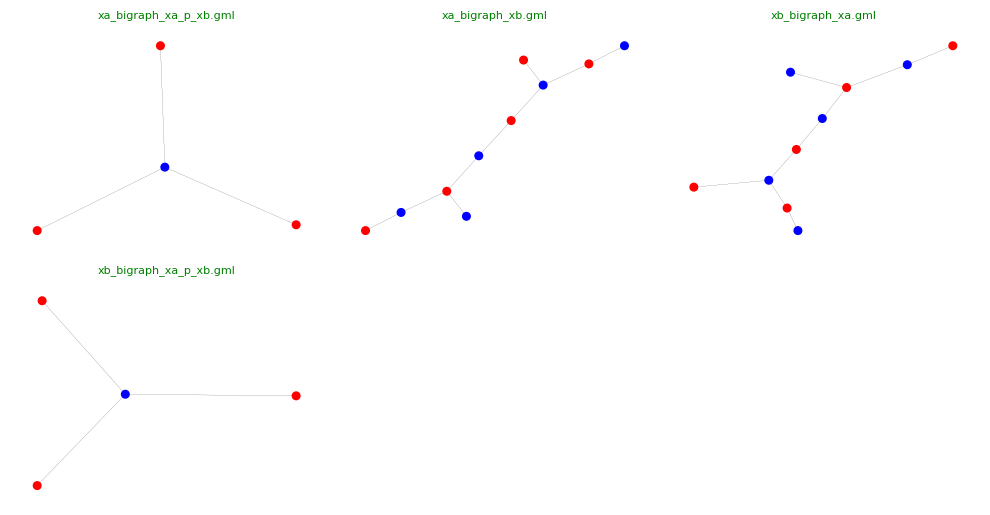

In [ ]:
# 5.1 Plot of sample bigraphs:
bigraphs = ['xa_bigraph_xa_p_xb.gml', 'xa_bigraph_xb.gml', 'xb_bigraph_xa.gml', 'xb_bigraph_xa_p_xb.gml']
plt.style.use('default')
pathToFolder = Path("/content/allmodels/models")
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _=utils.plotBipartiteGraph(bi,
                               pathToFolder,
                               ax = ax,
                               title = bi,
                               connected = True);
    plt.tight_layout();

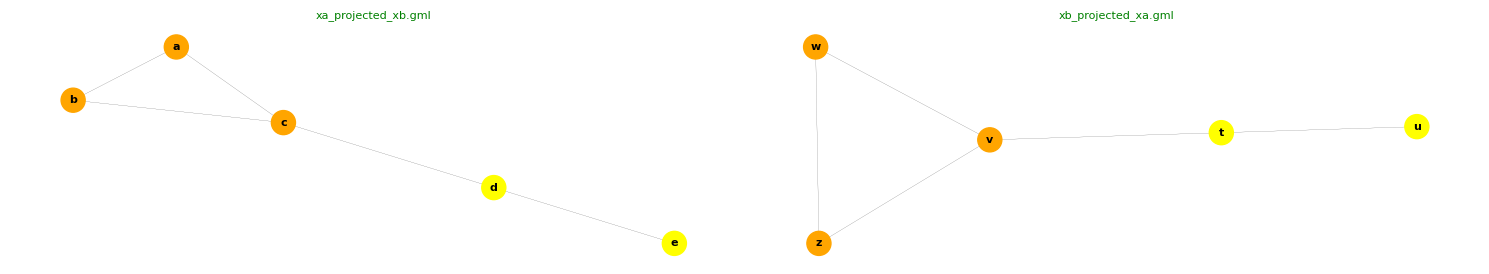

In [ ]:
# 5.2 Plot of  projected graph files
projected = [ 'xa_projected_xb.gml', 'xb_projected_xa.gml']
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   ax = ax,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

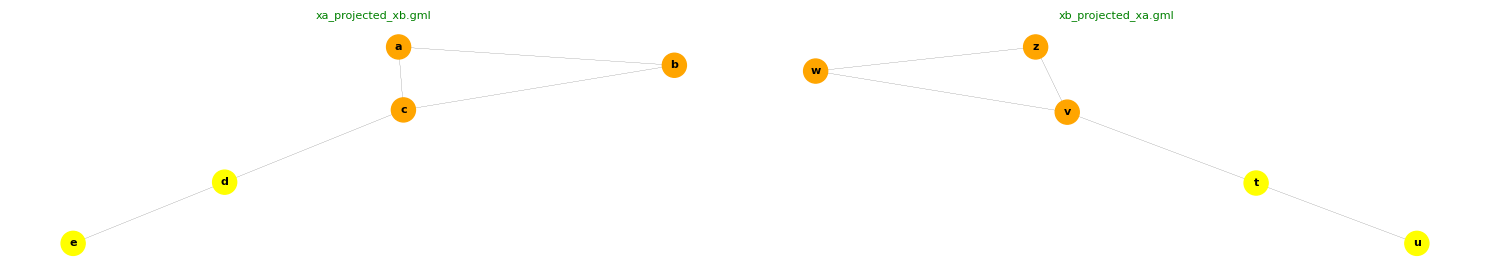

In [ ]:
# 5.3 Plot of  projected graph files community: algorithms.leiden
projected = [ 'xa_projected_xb.gml', 'xb_projected_xa.gml']
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   ax = ax,
                                   algo = algorithms.leiden,
                                   withLabels = True,
                                   title = prj);
    plt.tight_layout();

## Rough work

In [ ]:

G = nx.read_gml(pathToFolder /'xa_projected_xb.gml')

nx.clustering(G)

{'d': 0, 'b': 1.0, 'c': 0.3333333333333333, 'a': 1.0, 'e': 0}

In [ ]:
##################### DONE ####################